# Final Assignment - Applied data science capstone

### Background and business plan

I explore the potentiality of segmenting city's neighbours, but in the training part I explored big multicultural overseas cities like New York or Toronto. In the final assignment I want to explore and segment the city of Bari (Italy), which is a city nearby my hometown, not so famous among all italian cities but it's a very particular center mostly famous for its food tradition. I am simulating to be an investor who want to open a new restaurant that could represent a unique possibility to have international meals, e.g. mexican or thai food (which are not spread in southern italy) and in order to do that I want to know what will be the best neighbours to invest on.
I am starting from scratch and I doubt that there will be lots of informations to be used from foursquare, but I will do my best to offer the best options I can.

### Data collection

In order to pursue the work I decided to use neighbours data available at https://en.wikipedia.org/wiki/Bari#Quarters.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium

print('Libraries imported.')

     |████████████████████████████████| 93 kB 3.4 MB/s  eta 0:00:01
Libraries imported.


In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/Bari#Quarters')[2]
df.head()

,Municipi,Quarters,Former Circoscrizioni
0,1,"Murat, San Nicola, Libertà, Madonnella, Japigi...","V, VII, IX"
1,2,"Poggiofranco, Picone, Carrassi, San Pasquale, ...","III, VI"
2,3,"San Paolo, Stanic, Marconi, San Girolamo, Fesc...","II, VIII"
3,4,"Carbonara, Ceglie, Loseto",IV
4,5,"Palese, Santo Spirito, Catino, San Pio",I


In [3]:
#Split each quarter (previously gropued by "Municipi")
df1 = df['Quarters'].str.split(',').explode()
df1.reset_index()

,index,Quarters
0,0,Murat
1,0,San Nicola
2,0,Libertà
3,0,Madonnella
4,0,Japigia
5,0,Torre a mare
6,1,Poggiofranco
7,1,Picone
8,1,Carrassi
9,1,San Pasquale


In [4]:
#Remove last character ( ')' ) in row 16 
df1 = df1.to_frame()
df1['Quarters'].iloc[16] = df1['Quarters'].iloc[16][: -1]
df1.reset_index()

,index,Quarters
0,0,Murat
1,0,San Nicola
2,0,Libertà
3,0,Madonnella
4,0,Japigia
5,0,Torre a mare
6,1,Poggiofranco
7,1,Picone
8,1,Carrassi
9,1,San Pasquale


In [5]:
#Remove whitespace at the beginning of each quarter
df1['Quarters'] = df1['Quarters'].apply(lambda row: row.lstrip())

In [6]:
nc = ['Bari,'] * df1.shape[0]

In [7]:
df1['city'] = nc

In [8]:
df1['location'] = df1['city'] + df1['Quarters']
df1

,Quarters,city,location
0,Murat,"Bari,","Bari,Murat"
0,San Nicola,"Bari,","Bari,San Nicola"
0,Libertà,"Bari,","Bari,Libertà"
0,Madonnella,"Bari,","Bari,Madonnella"
0,Japigia,"Bari,","Bari,Japigia"
0,Torre a mare,"Bari,","Bari,Torre a mare"
1,Poggiofranco,"Bari,","Bari,Poggiofranco"
1,Picone,"Bari,","Bari,Picone"
1,Carrassi,"Bari,","Bari,Carrassi"
1,San Pasquale,"Bari,","Bari,San Pasquale"


In [9]:
df1['city'] = ['Bari'] * df1.shape[0]
df1.head()

,Quarters,city,location
0,Murat,Bari,"Bari,Murat"
0,San Nicola,Bari,"Bari,San Nicola"
0,Libertà,Bari,"Bari,Libertà"
0,Madonnella,Bari,"Bari,Madonnella"
0,Japigia,Bari,"Bari,Japigia"


In [10]:
#Add coordinates for each quarter
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="Bari_quar")

df1['Dist_Coord']= df1['location'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df1[['Latitude', 'Longitude']] = df1['Dist_Coord'].apply(pd.Series)

df1.drop(['Dist_Coord'], axis=1, inplace=True)
df1

,Quarters,city,location,Latitude,Longitude
0,Murat,Bari,"Bari,Murat",41.123301,16.870601
0,San Nicola,Bari,"Bari,San Nicola",41.128054,16.869299
0,Libertà,Bari,"Bari,Libertà",41.123126,16.856248
0,Madonnella,Bari,"Bari,Madonnella",41.120257,16.884253
0,Japigia,Bari,"Bari,Japigia",41.113869,16.896594
0,Torre a mare,Bari,"Bari,Torre a mare",41.087498,17.000413
1,Poggiofranco,Bari,"Bari,Poggiofranco",41.090048,16.857068
1,Picone,Bari,"Bari,Picone",41.070221,16.860594
1,Carrassi,Bari,"Bari,Carrassi",41.089559,16.870042
1,San Pasquale,Bari,"Bari,San Pasquale",41.113456,16.876145


In [11]:
#Coordinate of the city of Bari
address = 'Bari, Italy'

geolocator = Nominatim(user_agent="Bari_quar")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bari are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bari are 41.1257843, 16.8620293.


In [12]:
# create map of Bari using latitude and longitude 
map_bari = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
for lat, lng, label in zip(df1['Latitude'], df1['Longitude'], df1['Quarters']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bari) 
    
map_bari

In [13]:
#After viewing the map I decided to remove "San Pio quarter" as well as "S.Spirito" and "San Girolamo" since they're located wrongly 
df1 = df1.reset_index()
df1.drop(index=14, axis=0, inplace=True)
df1.drop(index=21, axis=0, inplace=True)
df1.drop(index=23, axis=0, inplace=True)
df1 = df1.reset_index()
df1.head()


,level_0,index,Quarters,city,location,Latitude,Longitude
0,0,0,Murat,Bari,"Bari,Murat",41.123301,16.870601
1,1,0,San Nicola,Bari,"Bari,San Nicola",41.128054,16.869299
2,2,0,Libertà,Bari,"Bari,Libertà",41.123126,16.856248
3,3,0,Madonnella,Bari,"Bari,Madonnella",41.120257,16.884253
4,4,0,Japigia,Bari,"Bari,Japigia",41.113869,16.896594


In [14]:
df1.drop('level_0', axis=1, inplace=True)
df1

,index,Quarters,city,location,Latitude,Longitude
0,0,Murat,Bari,"Bari,Murat",41.123301,16.870601
1,0,San Nicola,Bari,"Bari,San Nicola",41.128054,16.869299
2,0,Libertà,Bari,"Bari,Libertà",41.123126,16.856248
3,0,Madonnella,Bari,"Bari,Madonnella",41.120257,16.884253
4,0,Japigia,Bari,"Bari,Japigia",41.113869,16.896594
5,0,Torre a mare,Bari,"Bari,Torre a mare",41.087498,17.000413
6,1,Poggiofranco,Bari,"Bari,Poggiofranco",41.090048,16.857068
7,1,Picone,Bari,"Bari,Picone",41.070221,16.860594
8,1,Carrassi,Bari,"Bari,Carrassi",41.089559,16.870042
9,1,San Pasquale,Bari,"Bari,San Pasquale",41.113456,16.876145


In [15]:
# create map of Bari using latitude and longitude 
map_bari = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
for lat, lng, label in zip(df1['Latitude'], df1['Longitude'], df1['Quarters']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bari) 
    
map_bari

# Methodology

Once data is collected the following codes are used to parse those data.

In [16]:
CLIENT_ID = 'JPJXFIOZCFZ4OTQUKZWJSY0POGOO3HWCE0FRUDBZBJIEYBPG' # your Foursquare ID
CLIENT_SECRET = '4O12D24WU5TMMVQG5J503SAR5PM14VXBSBSBIEPLMBFAAFD1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
bari_venues = getNearbyVenues(names=df1['Quarters'], latitudes=df1['Latitude'], longitudes=df1['Longitude'])

Murat
San Nicola
Libertà
Madonnella
Japigia
Torre a mare
Poggiofranco
Picone
Carrassi
San Pasquale
Mungivacca
San Paolo
Stanic
Marconi
Fesca
Villaggio del Lavoratore
Carbonara
Ceglie
Loseto
Palese
Catino


In [19]:
bari_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Murat,41.123301,16.870601,Teatro Petruzzelli,41.123595,16.872725,Theater
1,Murat,41.123301,16.870601,Feltrinelli,41.122561,16.871287,Bookstore
2,Murat,41.123301,16.870601,Frulez,41.121378,16.870101,Vegetarian / Vegan Restaurant
3,Murat,41.123301,16.870601,Ai 2 Ghiottoni,41.123485,16.871487,Italian Restaurant
4,Murat,41.123301,16.870601,Louis Vuitton,41.121940,16.869660,Boutique


In [20]:
bari_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Carbonara,3,3,3,3,3,3
Carrassi,7,7,7,7,7,7
Catino,11,11,11,11,11,11
Ceglie,6,6,6,6,6,6
Fesca,3,3,3,3,3,3
Japigia,6,6,6,6,6,6
Libertà,11,11,11,11,11,11
Loseto,3,3,3,3,3,3
Madonnella,9,9,9,9,9,9


In [21]:
bari_onehot = pd.get_dummies(bari_venues['Venue Category'], prefix="", prefix_sep="")
bari_onehot['Neighborhood'] = bari_venues['Neighborhood']
bari_onehot.head()

,Art Gallery,Art Museum,Arts & Entertainment,BBQ Joint,Bakery,Bar,Beach,Beer Garden,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Café,Cocktail Bar,Coffee Shop,Cupcake Shop,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Dog Run,Electronics Store,Fast Food Restaurant,Food,Food Truck,Funeral Home,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Home Service,Hotel,Hotel Pool,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lounge,Mediterranean Restaurant,Metro Station,Modern European Restaurant,Movie Theater,Music Venue,Optical Shop,Pizza Place,Plaza,Pub,Puglia Restaurant,Rental Car Location,Restaurant,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Smoke Shop,Soccer Field,Steakhouse,Theater,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Murat
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Murat
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Murat
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Murat
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Murat


In [22]:
bari_grouped = bari_onehot.groupby('Neighborhood').mean().reset_index()
bari_grouped.head()

,Neighborhood,Art Gallery,Art Museum,Arts & Entertainment,BBQ Joint,Bakery,Bar,Beach,Beer Garden,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Café,Cocktail Bar,Coffee Shop,Cupcake Shop,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Dog Run,Electronics Store,Fast Food Restaurant,Food,Food Truck,Funeral Home,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Home Service,Hotel,Hotel Pool,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lounge,Mediterranean Restaurant,Metro Station,Modern European Restaurant,Movie Theater,Music Venue,Optical Shop,Pizza Place,Plaza,Pub,Puglia Restaurant,Rental Car Location,Restaurant,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Smoke Shop,Soccer Field,Steakhouse,Theater,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Wine Bar
0,Carbonara,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0
1,Carrassi,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.285714,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.142857,0.142857,0.0,0.0,0.0,0.000000,0.0,0.0
2,Catino,0.0,0.0,0.0,0.0,0.0,0.090909,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.090909,0.0,0.000000,0.000000,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.090909,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0
3,Ceglie,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.166667,0.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,Fesca,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0


In [23]:
num_top_venues = 5

for hood in bari_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bari_grouped[bari_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Carbonara----
           venue  freq
0  Train Station  0.33
1   Home Service  0.33
2   Dance Studio  0.33
3    Art Gallery  0.00
4         Lounge  0.00


----Carrassi----
          venue  freq
0   Pizza Place  0.29
1           Bar  0.14
2    Restaurant  0.14
3  Soccer Field  0.14
4    Smoke Shop  0.14


----Catino----
                venue  freq
0                Café  0.27
1     Harbor / Marina  0.09
2               Beach  0.09
3          Restaurant  0.09
4  Seafood Restaurant  0.09


----Ceglie----
                     venue  freq
0              Music Venue  0.33
1  Health & Beauty Service  0.17
2             Home Service  0.17
3                     Café  0.17
4               Food Truck  0.17


----Fesca----
                 venue  freq
0        Train Station  0.33
1        Metro Station  0.33
2    Electronics Store  0.33
3          Art Gallery  0.00
4  Japanese Restaurant  0.00


----Japigia----
                      venue  freq
0                   Dog Run  0.17
1                

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bari_grouped['Neighborhood']

for ind in np.arange(bari_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bari_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carbonara,Train Station,Dance Studio,Home Service,Wine Bar,Dog Run,Department Store,Design Studio,Dessert Shop,Diner,Fast Food Restaurant
1,Carrassi,Pizza Place,Grocery Store,Soccer Field,Smoke Shop,Bar,Restaurant,Wine Bar,Diner,Dance Studio,Department Store
2,Catino,Café,Train Station,Harbor / Marina,Bar,Seafood Restaurant,Beach,Pizza Place,Restaurant,Ice Cream Shop,Wine Bar
3,Ceglie,Music Venue,Café,Food Truck,Health & Beauty Service,Home Service,Wine Bar,Diner,Dance Studio,Department Store,Design Studio
4,Fesca,Electronics Store,Train Station,Metro Station,Dog Run,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Wine Bar


In [26]:
# set number of clusters
kclusters = 5

bari_grouped_clustering = bari_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bari_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 1, 1, 0, 1, 1, 3, 1, 1], dtype=int32)

In [27]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
bari_merged = df1
bari_merged = bari_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Quarters')
bari_merged.reset_index()
bari_merged

,index,Quarters,city,location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Murat,Bari,"Bari,Murat",41.123301,16.870601,1,Café,Italian Restaurant,Restaurant,Bookstore,Ice Cream Shop,Pizza Place,Plaza,Pub,Boutique,Seafood Restaurant
1,0,San Nicola,Bari,"Bari,San Nicola",41.128054,16.869299,1,Italian Restaurant,Ice Cream Shop,Café,Pizza Place,Plaza,Mediterranean Restaurant,Diner,Bar,Seafood Restaurant,Restaurant
2,0,Libertà,Bari,"Bari,Libertà",41.123126,16.856248,1,Pizza Place,Café,Food,Steakhouse,Hardware Store,Plaza,Hotel,Pub,Design Studio,Cupcake Shop
3,0,Madonnella,Bari,"Bari,Madonnella",41.120257,16.884253,1,Café,Pub,Hotel,Pizza Place,Movie Theater,Dessert Shop,Cupcake Shop,Dance Studio,Department Store,Design Studio
4,0,Japigia,Bari,"Bari,Japigia",41.113869,16.896594,1,Bike Rental / Bike Share,BBQ Joint,Bakery,Bar,Café,Dog Run,Fast Food Restaurant,Design Studio,Dessert Shop,Diner
5,0,Torre a mare,Bari,"Bari,Torre a mare",41.087498,17.000413,1,Café,Italian Restaurant,Seafood Restaurant,Pizza Place,Gastropub,Diner,Sandwich Place,Bar,Food,Harbor / Marina
6,1,Poggiofranco,Bari,"Bari,Poggiofranco",41.090048,16.857068,1,Italian Restaurant,Pizza Place,Café,Bar,Cupcake Shop,Wine Bar,Department Store,Design Studio,Dessert Shop,Diner
7,1,Picone,Bari,"Bari,Picone",41.070221,16.860594,1,Grocery Store,Cocktail Bar,Home Service,Hotel Pool,Electronics Store,Department Store,Design Studio,Dessert Shop,Diner,Dog Run
8,1,Carrassi,Bari,"Bari,Carrassi",41.089559,16.870042,1,Pizza Place,Grocery Store,Soccer Field,Smoke Shop,Bar,Restaurant,Wine Bar,Diner,Dance Studio,Department Store
9,1,San Pasquale,Bari,"Bari,San Pasquale",41.113456,16.876145,1,Café,Italian Restaurant,Dessert Shop,Cocktail Bar,Ice Cream Shop,Art Museum,Japanese Restaurant,Bakery,Pizza Place,Pub


In [28]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [29]:
bari_merged.isnull().sum().sum()

0

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)



# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bari_merged['Latitude'], bari_merged['Longitude'], bari_merged['Quarters'], bari_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [31]:
bari_merged.loc[bari_merged['Cluster Labels'] == 0, bari_merged.columns[[1] + list(range(7, bari_merged.shape[1]))]]


,Quarters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Fesca,Electronics Store,Train Station,Metro Station,Dog Run,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Wine Bar
16,Carbonara,Train Station,Dance Studio,Home Service,Wine Bar,Dog Run,Department Store,Design Studio,Dessert Shop,Diner,Fast Food Restaurant


In [32]:
bari_merged.loc[bari_merged['Cluster Labels'] == 1, bari_merged.columns[[1] + list(range(7, bari_merged.shape[1]))]]


,Quarters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Murat,Café,Italian Restaurant,Restaurant,Bookstore,Ice Cream Shop,Pizza Place,Plaza,Pub,Boutique,Seafood Restaurant
1,San Nicola,Italian Restaurant,Ice Cream Shop,Café,Pizza Place,Plaza,Mediterranean Restaurant,Diner,Bar,Seafood Restaurant,Restaurant
2,Libertà,Pizza Place,Café,Food,Steakhouse,Hardware Store,Plaza,Hotel,Pub,Design Studio,Cupcake Shop
3,Madonnella,Café,Pub,Hotel,Pizza Place,Movie Theater,Dessert Shop,Cupcake Shop,Dance Studio,Department Store,Design Studio
4,Japigia,Bike Rental / Bike Share,BBQ Joint,Bakery,Bar,Café,Dog Run,Fast Food Restaurant,Design Studio,Dessert Shop,Diner
5,Torre a mare,Café,Italian Restaurant,Seafood Restaurant,Pizza Place,Gastropub,Diner,Sandwich Place,Bar,Food,Harbor / Marina
6,Poggiofranco,Italian Restaurant,Pizza Place,Café,Bar,Cupcake Shop,Wine Bar,Department Store,Design Studio,Dessert Shop,Diner
7,Picone,Grocery Store,Cocktail Bar,Home Service,Hotel Pool,Electronics Store,Department Store,Design Studio,Dessert Shop,Diner,Dog Run
8,Carrassi,Pizza Place,Grocery Store,Soccer Field,Smoke Shop,Bar,Restaurant,Wine Bar,Diner,Dance Studio,Department Store
9,San Pasquale,Café,Italian Restaurant,Dessert Shop,Cocktail Bar,Ice Cream Shop,Art Museum,Japanese Restaurant,Bakery,Pizza Place,Pub


In [33]:
bari_merged.loc[bari_merged['Cluster Labels'] == 2, bari_merged.columns[[1] + list(range(7, bari_merged.shape[1]))]]


,Quarters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Villaggio del Lavoratore,Rental Car Location,Wine Bar,Dog Run,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Electronics Store,Coffee Shop


In [34]:
bari_merged.loc[bari_merged['Cluster Labels'] == 3, bari_merged.columns[[1] + list(range(7, bari_merged.shape[1]))]]


,Quarters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Loseto,Art Gallery,Funeral Home,Bakery,Dog Run,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Fast Food Restaurant


In [35]:
bari_merged.loc[bari_merged['Cluster Labels'] == 4, bari_merged.columns[[1] + list(range(7, bari_merged.shape[1]))]]


,Quarters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,San Paolo,Optical Shop,Dog Run,Cupcake Shop,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Electronics Store,Grocery Store


# Business target - Restaurant

After exploring all the venues in the city of Bari I focus on Restaurant which represent the business goal.

In [36]:
# Create a Data-Frame out of it to concentrate only on Restaurants 
bari_Venues_only_restaurant = bari_venues[bari_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
bari_Venues_only_restaurant.index = np.arange(1, len(bari_Venues_only_restaurant )+1)
print (bari_Venues_only_restaurant['Venue Category'].value_counts())


Italian Restaurant               17
Restaurant                        7
Seafood Restaurant                7
Mediterranean Restaurant          3
Fast Food Restaurant              3
Japanese Restaurant               2
Modern European Restaurant        1
Greek Restaurant                  1
Vegetarian / Vegan Restaurant     1
Puglia Restaurant                 1
Scandinavian Restaurant           1
Name: Venue Category, dtype: int64


In [37]:
# create a dataframe of top 10 categories
bari_Venues_Top10 = bari_Venues_only_restaurant['Venue Category'].value_counts()[0:11].to_frame(name='frequency')
bari_Venues_Top10= bari_Venues_Top10.reset_index()
bari_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
bari_Venues_Top10

,Venue_Category,Frequency
0,Italian Restaurant,17
1,Restaurant,7
2,Seafood Restaurant,7
3,Mediterranean Restaurant,3
4,Fast Food Restaurant,3
5,Japanese Restaurant,2
6,Modern European Restaurant,1
7,Greek Restaurant,1
8,Vegetarian / Vegan Restaurant,1
9,Puglia Restaurant,1


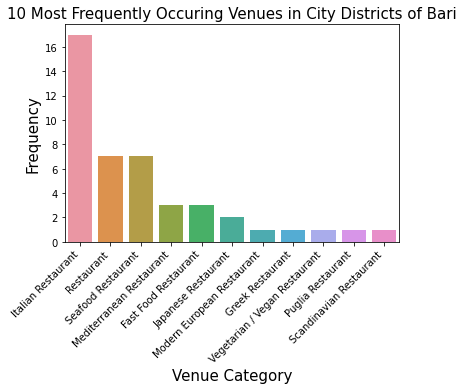

<Figure size 1296x504 with 0 Axes>

In [38]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=bari_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Venues in City Districts of Bari', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [39]:
bari_Venues_only_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Murat,41.123301,16.870601,Frulez,41.121378,16.870101,Vegetarian / Vegan Restaurant
2,Murat,41.123301,16.870601,Ai 2 Ghiottoni,41.123485,16.871487,Italian Restaurant
3,Murat,41.123301,16.870601,Bacio di Latte House,41.125588,16.869261,Restaurant
4,Murat,41.123301,16.870601,Vini e Cucina,41.126601,16.871669,Italian Restaurant
5,Murat,41.123301,16.870601,La Piazzetta,41.122110,16.870150,Puglia Restaurant


In [40]:
bari_Venues_only_restaurant.groupby('Neighborhood').head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Murat,41.123301,16.870601,Frulez,41.121378,16.870101,Vegetarian / Vegan Restaurant
2,Murat,41.123301,16.870601,Ai 2 Ghiottoni,41.123485,16.871487,Italian Restaurant
3,Murat,41.123301,16.870601,Bacio di Latte House,41.125588,16.869261,Restaurant
4,Murat,41.123301,16.870601,Vini e Cucina,41.126601,16.871669,Italian Restaurant
5,Murat,41.123301,16.870601,La Piazzetta,41.122110,16.870150,Puglia Restaurant
16,San Nicola,41.128054,16.869299,La Uascezze,41.128720,16.871729,Italian Restaurant
17,San Nicola,41.128054,16.869299,La Cecchina,41.128038,16.871651,Italian Restaurant
18,San Nicola,41.128054,16.869299,L'osteria del borgo antico,41.127740,16.871500,Italian Restaurant
19,San Nicola,41.128054,16.869299,Bacio di Latte House,41.125588,16.869261,Restaurant
20,San Nicola,41.128054,16.869299,Gyrosteria Yannis,41.128150,16.872820,Greek Restaurant


In [41]:
bari_Venues_restaurant = bari_Venues_only_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
bari_Venues_restaurant

Neighborhood
Carrassi         1
Catino           2
Mungivacca       2
Murat           15
Poggiofranco     2
San Nicola      14
San Pasquale     3
Torre a mare     5
Name: Venue Category, dtype: int64

In [42]:
bari_Venues_restaurant_df  = bari_Venues_restaurant.to_frame().reset_index()
bari_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
bari_Venues_restaurant_df.index = np.arange(1, len(bari_Venues_restaurant_df)+1)
list_rest_no =bari_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =bari_Venues_restaurant_df['Neighborhood'].to_list()

In [43]:
# one hot encoding
bari_onehot_rest = pd.get_dummies(bari_Venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
bari_onehot_rest['Neighborhood'] = bari_Venues_only_restaurant['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [bari_onehot_rest.columns[-1]] + list(bari_onehot_rest.columns[:-1])
bari_onehot_rest = bari_onehot_rest[fixed_columns]

bari_onehot_rest.head()

,Neighborhood,Fast Food Restaurant,Greek Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Modern European Restaurant,Puglia Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant
1,Murat,0,0,0,0,0,0,0,0,0,0,1
2,Murat,0,0,1,0,0,0,0,0,0,0,0
3,Murat,0,0,0,0,0,0,0,1,0,0,0
4,Murat,0,0,1,0,0,0,0,0,0,0,0
5,Murat,0,0,0,0,0,0,1,0,0,0,0


In [44]:
bari_grouped_rest = bari_onehot_rest.groupby('Neighborhood').mean().reset_index()
bari_grouped_rest

,Neighborhood,Fast Food Restaurant,Greek Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Modern European Restaurant,Puglia Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant
0,Carrassi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
1,Catino,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.500000,0.000000
2,Mungivacca,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000
3,Murat,0.133333,0.000000,0.266667,0.000000,0.066667,0.066667,0.066667,0.200000,0.0,0.133333,0.066667
4,Poggiofranco,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,San Nicola,0.000000,0.071429,0.428571,0.071429,0.142857,0.000000,0.000000,0.142857,0.0,0.142857,0.000000
6,San Pasquale,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,Torre a mare,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.400000,0.000000


In [45]:

num_top_venues = 10

for hood in bari_grouped_rest['Neighborhood']:
    print("----"+hood+"----")
    temp = bari_grouped_rest[bari_grouped_rest['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Carrassi----
                        venue  freq
0                  Restaurant   1.0
1        Fast Food Restaurant   0.0
2            Greek Restaurant   0.0
3          Italian Restaurant   0.0
4         Japanese Restaurant   0.0
5    Mediterranean Restaurant   0.0
6  Modern European Restaurant   0.0
7           Puglia Restaurant   0.0
8     Scandinavian Restaurant   0.0
9          Seafood Restaurant   0.0


----Catino----
                        venue  freq
0                  Restaurant   0.5
1          Seafood Restaurant   0.5
2        Fast Food Restaurant   0.0
3            Greek Restaurant   0.0
4          Italian Restaurant   0.0
5         Japanese Restaurant   0.0
6    Mediterranean Restaurant   0.0
7  Modern European Restaurant   0.0
8           Puglia Restaurant   0.0
9     Scandinavian Restaurant   0.0


----Mungivacca----
                        venue  freq
0        Fast Food Restaurant   0.5
1     Scandinavian Restaurant   0.5
2            Greek Restaurant   0.0
3        

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_rest = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_rest['Neighborhood'] = bari_grouped_rest['Neighborhood']

for ind in np.arange(bari_grouped_rest.shape[0]):
    neighborhoods_venues_sorted_rest.iloc[ind, 1:] = return_most_common_venues(bari_grouped_rest.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_rest.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrassi,Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant
1,Catino,Seafood Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant
2,Mungivacca,Scandinavian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant
3,Murat,Italian Restaurant,Restaurant,Seafood Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Scandinavian Restaurant,Japanese Restaurant
4,Poggiofranco,Italian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant


In [47]:
#set number of clusters (I choose 5)
kclusters = 5

bari_grouped_clustering_rest = bari_grouped_rest.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bari_grouped_clustering_rest)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 4, 3, 0, 1, 0, 1, 0], dtype=int32)

In [48]:
neighborhoods_venues_sorted_clusters_rest = neighborhoods_venues_sorted_rest
# add clustering labels
neighborhoods_venues_sorted_clusters_rest.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted_clusters_rest.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Carrassi,Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant
1,4,Catino,Seafood Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant
2,3,Mungivacca,Scandinavian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant
3,0,Murat,Italian Restaurant,Restaurant,Seafood Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Scandinavian Restaurant,Japanese Restaurant
4,1,Poggiofranco,Italian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant


In [49]:
bari_merged_rest = df1.join(neighborhoods_venues_sorted_rest.set_index('Neighborhood'), on='Quarters')

bari_merged_rest.head(10)

,index,Quarters,city,location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Murat,Bari,"Bari,Murat",41.123301,16.870601,0.0,Italian Restaurant,Restaurant,Seafood Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Scandinavian Restaurant,Japanese Restaurant
1,0,San Nicola,Bari,"Bari,San Nicola",41.128054,16.869299,0.0,Italian Restaurant,Seafood Restaurant,Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant
2,0,Libertà,Bari,"Bari,Libertà",41.123126,16.856248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Madonnella,Bari,"Bari,Madonnella",41.120257,16.884253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Japigia,Bari,"Bari,Japigia",41.113869,16.896594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,Torre a mare,Bari,"Bari,Torre a mare",41.087498,17.000413,0.0,Italian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant
6,1,Poggiofranco,Bari,"Bari,Poggiofranco",41.090048,16.857068,1.0,Italian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant
7,1,Picone,Bari,"Bari,Picone",41.070221,16.860594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,Carrassi,Bari,"Bari,Carrassi",41.089559,16.870042,2.0,Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant
9,1,San Pasquale,Bari,"Bari,San Pasquale",41.113456,16.876145,1.0,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Greek Restaurant


In [50]:
bari_merged_rest.dropna(inplace=True)
bari_merged_rest

,index,Quarters,city,location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Murat,Bari,"Bari,Murat",41.123301,16.870601,0.0,Italian Restaurant,Restaurant,Seafood Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Scandinavian Restaurant,Japanese Restaurant
1,0,San Nicola,Bari,"Bari,San Nicola",41.128054,16.869299,0.0,Italian Restaurant,Seafood Restaurant,Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant
5,0,Torre a mare,Bari,"Bari,Torre a mare",41.087498,17.000413,0.0,Italian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant
6,1,Poggiofranco,Bari,"Bari,Poggiofranco",41.090048,16.857068,1.0,Italian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant
8,1,Carrassi,Bari,"Bari,Carrassi",41.089559,16.870042,2.0,Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant
9,1,San Pasquale,Bari,"Bari,San Pasquale",41.113456,16.876145,1.0,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Greek Restaurant
10,1,Mungivacca,Bari,"Bari,Mungivacca",41.090225,16.900127,3.0,Scandinavian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant
20,4,Catino,Bari,"Bari,Catino",41.163358,16.746813,4.0,Seafood Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant


In [51]:
# create map
map_rest = folium.Map(location=[latitude, longitude], zoom_start=10)



# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bari_merged_rest['Latitude'], bari_merged_rest['Longitude'], bari_merged_rest['Quarters'], bari_merged_rest['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_rest)
       
map_rest

In [52]:
bari_merged_rest.loc[bari_merged_rest['Cluster Labels'] == 0, bari_merged_rest.columns[[1] + list(range(7, bari_merged_rest.shape[1]))]]


,Quarters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Murat,Italian Restaurant,Restaurant,Seafood Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Scandinavian Restaurant,Japanese Restaurant
1,San Nicola,Italian Restaurant,Seafood Restaurant,Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant
5,Torre a mare,Italian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant


The first cluster can identify mostly Italian and Seafood restaurant

In [53]:
bari_merged_rest.loc[bari_merged_rest['Cluster Labels'] == 1, bari_merged_rest.columns[[1] + list(range(7, bari_merged_rest.shape[1]))]]


,Quarters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Poggiofranco,Italian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Greek Restaurant
9,San Pasquale,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Greek Restaurant


The cluster = 1 define Italian restaurant but also vegetarian and vegan menu

In [54]:
bari_merged_rest.loc[bari_merged_rest['Cluster Labels'] == 2, bari_merged_rest.columns[[1] + list(range(7, bari_merged_rest.shape[1]))]]


,Quarters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Carrassi,Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant


In [55]:
bari_merged_rest.loc[bari_merged_rest['Cluster Labels'] == 3, bari_merged_rest.columns[[1] + list(range(7, bari_merged_rest.shape[1]))]]


,Quarters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Mungivacca,Scandinavian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant


Cluster n 3 identify international and fast food restaurant

In [56]:
bari_merged_rest.loc[bari_merged_rest['Cluster Labels'] == 4, bari_merged_rest.columns[[1] + list(range(7, bari_merged_rest.shape[1]))]]


,Quarters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Catino,Seafood Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Puglia Restaurant,Modern European Restaurant,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant,Greek Restaurant


# Conclusion

After cleaning and parsing data about Restaurant clustering around the city of Bari we can see that there are few neighbours that contain the majority of restaurant of the entire area. The following table highlights the total number of restaurants per neighbours.

In [63]:
bari_Venues_restaurant

Neighborhood
Carrassi         1
Catino           2
Mungivacca       2
Murat           15
Poggiofranco     2
San Nicola      14
San Pasquale     3
Torre a mare     5
Name: Venue Category, dtype: int64

### Top 3

We can state that "Murat" and "San Nicola" are the top two neighbours if we consider the number of operating restaurants. This is consistent with the fact that these are two central neighbours located in the turistic area of the city.

The third neighbours in absolute number of restaurant is "Torre a Mare" which is a small centre near Bari that is famous for its seafood restaurant which are characterized by their view. All of the restaurant are located by the sea so it is very popular if you wanna experience a meal in front of the blue adriatic sea.

These three neighbours represent cluster 0 and of course they are the best choice if an investor want to open a new activity. The centrality of these with respect to the city and their touristic attraction that characterize these borough are the two major reason that attract someone to invest on.


### Top 4th and 5th

The cluster number 1 respresent a very peculiar group. This is composed by "Poggiofranco" and "San Pasquale" that are the Univeristy neighbours. These represent good neighbours marked by young people in which one can experience vegetarian, vegan and international food.

### Cluster n.3

Cluster n 3 represents a very peculiar one. It is located at city borders and it's characterized by fast food located on the highway.

# Discussion

Considering the conclusion, if I am and investor and I want to open an international food restaurant (e.g Mexican or Thai etc.) the first thing that I have to ask myself is if I want to open a fast food or a restaurant. If I choose fast food option I can state that Mungivacca is the best neighbours in which invest on.
If I want to open a restaurant in a very populated, touristic and easily accessable neighbours I can look at cluster one and in particular "Murat" and "San Nicola" neighbours, located at city center.